# 9. Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [188]:
print(digits['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [189]:
X = digits['data']
y = digits['target']

print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


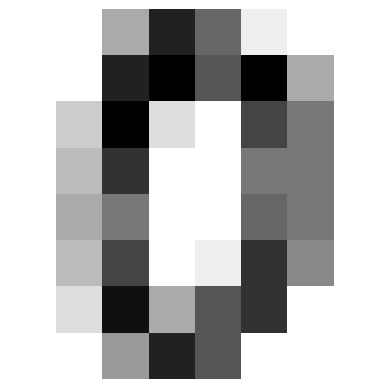

In [190]:
import matplotlib as mpl

def plot_digit(data):
    """Plots one 8x8 digit image.

    Args:
        data (np array): Np array of shape (64, 1) representing a digit image.
    """

    image = data.reshape(8, 8)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

plot_digit(X[0])

In [191]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1437, 64)
(360, 64)
(1437,)
(360,)


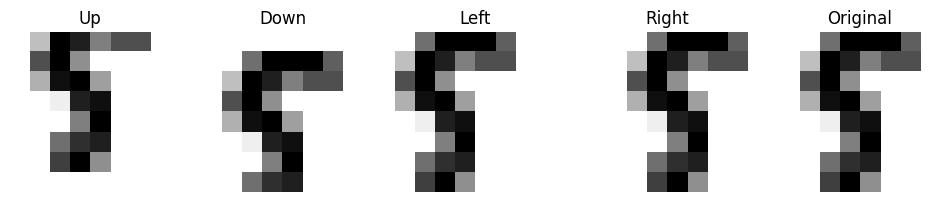

In [192]:
def shift_digits(X, y):
    """Create 4 copies of the digit, shifted one pixel in each direction.

    Args:
        X (Pandas df): The digits.
        y (Pandas df): The labels.

    Returns:
        np.array: The shifted digits.
    """
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Check if it is a single row
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    if len(y.shape) == 1:
        y = y.reshape(1, -1)
        

    # Reshape to 8x8
    X = X.reshape(-1, 8, 8)

    # Each image is shifted one pixel to each directions. If the shift goes out, the pixel is set to 0
    digits_shifted = np.array([
        # Up
        np.concatenate((X[:, 1:, :], np.zeros((X.shape[0], 1, 8))), axis=1).reshape(-1, 64),
        # Down
        np.concatenate((np.zeros((X.shape[0], 1, 8)), X[:, :-1, :]), axis=1).reshape(-1, 64),
        # Left
        np.concatenate((X[:, :, 1:], np.zeros((X.shape[0], 8, 1))), axis=2).reshape(-1, 64),
        # Right
        np.concatenate((np.zeros((X.shape[0], 8, 1)), X[:, :, :-1]), axis=2).reshape(-1, 64)
    ])     
    # Unravel and add the original image
    digits_shifted = digits_shifted.reshape(-1, 64)
    digits_shifted = np.concatenate((digits_shifted, X.reshape(-1, 64)), axis=0)

    # Repeat the labels
    y = np.repeat(y, 5, axis=0).reshape(-1, 1)

    return digits_shifted, y

def plot_shifted(X, y):
    """Shifts a digit and plots the result.

    Args:
        digit (np.array): The digit to be shifted.
        label (int): The label of the digit.
    """
    digits_shifted, y = shift_digits(X, y)
    plt.figure(figsize=(12, 3))
    dirs = ['Up', 'Down', 'Left', 'Right', 'Original']
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(digits_shifted[i].reshape(8, 8), cmap=mpl.cm.binary)  # Use binary color map
        plt.title(dirs[i])
        plt.axis('off')
    plt.show()
    

plot_shifted(X_train[123], y_train[123])

In [193]:
# Apply the augmentation to the dataset
X_aug, y_aug = shift_digits(X_train, y_train)

print(X_aug.shape)
print(y_aug.shape)

(7185, 64)
(7185, 1)


In [194]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

Cs = [0.01, 0.1, 1, 10, 100, 1000]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [2, 3]
gamma = ['scale', 'auto']
coef0 = [0.1]
shrinking = [True, False]
class_weight = ['balanced']

param_grid = {
    'svc_clf__C': Cs,
    'svc_clf__kernel': kernel,
    'svc_clf__degree': degree,
    'svc_clf__gamma': gamma,
    'svc_clf__coef0': coef0,
    'svc_clf__shrinking': shrinking,
    'svc_clf__class_weight': class_weight
}

pipe = Pipeline((
    ("std_scaler", StandardScaler()),
    ("svc_clf", SVC())
))

gs = GridSearchCV(
    pipe,
    param_grid,
    n_jobs=-1,
    cv=3,
    verbose=10
)

In [195]:
gs.fit(X_aug, y_aug) # Using original dataset on low spec machine

Fitting 3 folds for each of 192 candidates, totalling 576 fits


In [ ]:
best_model = gs.best_estimator_
print('Best model: ', best_model)

Best model:  Pipeline(steps=[('std_scaler', StandardScaler()),
                ('svc_clf',
                 SVC(C=10, class_weight='balanced', coef0=0.1, degree=2,
                     kernel='poly'))])


In [ ]:
# Make predictions
y_pred = best_model.predict(X_test)

In [ ]:
# Measure performance. Precision, recall, F1 score, ROC-AUC score. Weighted.

from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, recall, F1 score
print("Precision: ", precision_score(y_test, y_pred, average='weighted'))
print("Recall: ", recall_score(y_test, y_pred, average='weighted'))
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))

# Confusion matrix for all 10 digits
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n", conf_mx)



Precision:  0.9916955974683971
Recall:  0.9916666666666667
F1 score:  0.9916074580246119
Confusion matrix: 
 [[41  0  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 40  0  0  0  0  0  0]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  0  0  0  0 45  0  0  0  0]
 [ 0  0  0  0  0  0 40  0  0  0]
 [ 0  0  0  0  0  0  0 35  0  0]
 [ 0  0  0  0  0  0  0  0 37  1]
 [ 0  0  0  1  0  1  0  0  0 27]]


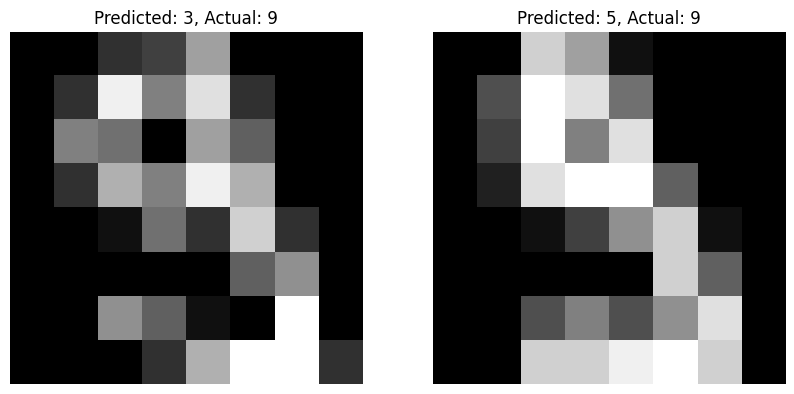

In [ ]:
# Plot any of the bad classified images
bad_classifs = np.where(y_pred != y_test)[0]

# Plot a pair of images and the corresponding labels
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[bad_classifs[i]].reshape(8, 8), cmap='gray')
    ax.set_title('Predicted: %d, Actual: %d' % (y_pred[bad_classifs[i]], y_test[bad_classifs[i]]))
    ax.axis('off')

plt.show()